In [3]:
# %% imports
%matplotlib inline
import tensorflow as tf
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers
from keras import backend as K
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
# from skimage import feature

import architecture

In [4]:
def read_and_decode_single_example(filename):
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string)
        })
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image = tf.cast(image, tf.float32) * (1. / 255)
    return image


def get_n_images(game, train, n=5000):
    if train is True:
        file_train = "full_images/" + game + "-" + "train" + ".tfrecords"
    else:
        file_train = "full_images/" + game + "-" + "valid" + ".tfrecords"

    # returns symbolic label and image
    image = read_and_decode_single_example(file_train)

    sess = tf.Session()

    # Required. See below for explanation
    init = tf.initialize_all_variables()
    sess.run(init)
    tf.train.start_queue_runners(sess=sess)

    # grab examples back.

    ims = []
    #     n = TRAIN_SIZE if train else VALID_SIZE
    for i in range(n):
        im = sess.run([image])
        ims.append(im[0])

    return ims

In [5]:
IMAGE_FOLDER = 'full_images'
GAME = 'Freeway'

x_train = get_n_images(GAME, train=True, n=2000)
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], 210, 160, 3))
x_med = np.median(x_train, axis=0)
x_train -= x_med
x_train += 1
x_train /= 2

x_valid = get_n_images(GAME, train=True, n=400)
x_valid = np.array(x_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 210, 160, 3))
x_valid -= x_med
x_valid += 1
x_valid /= 2

mn = architecture.MultiNetwork()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 210, 160, 3)   0                                            
____________________________________________________________________________________________________
conv4 (Model)                    (None, 2048)          11852640    input_4[0][0]                    
____________________________________________________________________________________________________
deconv4 (Model)                  (None, 210, 160, 3)   11922115    conv4[1][0]                      
Total params: 23,774,755
Trainable params: 23,758,563
Non-trainable params: 16,192
______________________________________________________________

In [8]:
mn.train_ae_gan(x_train)

[0.006984537, 0.0061767022, 0.001842194, 0.0011929697, 0.00060040213]

In [20]:
mn.autoencoder_gen.fit(x_train, x_train, nb_epoch=500, batch_size=32, shuffle=True, validation_data=(x_valid, x_valid))

Train on 2000 samples, validate on 400 samples
Epoch 1/500
2000/2000 [==============================] - 34s - loss: 0.0044 - val_loss: 0.0090

/home/ira/code/envs/flexi/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


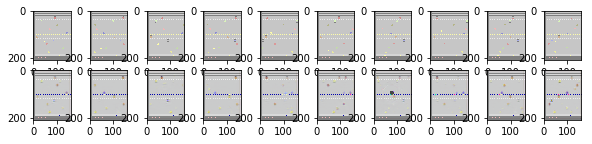

In [32]:
# Plot example reconstructions
n_examples = 10
# test_im = images_batch.eval(session=sess).reshape(150, 28, 28, 1)
indices = np.random.randint(0, x_valid.shape[0], size=(n_examples,))
# shift = 100
# print(shift)
test = x_valid[indices,:,:,:]
recon = mn.autoencoder_gen.predict(test)

fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    axs[0][example_i].imshow(test[example_i, :,:,:]+x_med/2, interpolation='none',
                            vmin=0, vmax=1.0)
#     axs[1][example_i].imshow(recon[example_i,:,:], cmap='gray')
    axs[1][example_i].imshow(recon[1*example_i, :,:,:]+x_med/2, interpolation='none',
                            vmin=0, vmax=1.0)
#     axs[2][example_i].imshow(code[1*example_i, :,:,0], cmap='gray', interpolation='none')
    
fig.show()
plt.draw()
example_i = 0

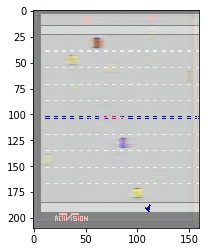

In [33]:
plt.imshow(recon[example_i,:,:,:]+x_med/2, interpolation='none',
                            vmin=0, vmax=1.0)
example_i += 1

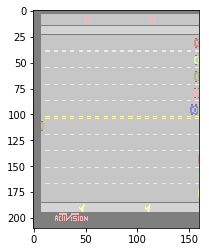

In [34]:
plt.imshow(x_train[2,:,:,:]+x_med/2, interpolation='none',
                            vmin=0, vmax=1.0)

In [29]:
np.max(recon)

2.5389032

In [30]:
np.max(test)

0.99411768

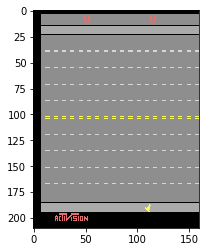

In [31]:
plt.imshow(x_med)

In [ ]:
mn.autoencoder_gen.save_weights('models/ae')